# Training and Evaluating Simple Regression Model

In [1]:
import toolz as fp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy.random as random
import sys
from importlib import reload
import shap

def reload_all(target):
    list(fp.map(lambda y: reload(sys.modules[y]) if sys.modules[y] else None, list(fp.remove(lambda x: target not in x, sys.modules.keys()))))

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
reload_all('fklearn')

In [3]:
from fklearn.training.transformation import capper, floorer, prediction_ranger
from fklearn.training.pipeline import build_pipeline

In [4]:
from fklearn.validation.evaluators import mean_prediction_evaluator, r2_evaluator, mse_evaluator, combined_evaluators
from fklearn.validation.validator import validator
from fklearn.validation.splitters import k_fold_splitter, out_of_time_and_space_splitter
from fklearn.documentation.pd_extractors import evaluator_extractor as pd_evaluator_extractor, extract as pd_extract, \
                                        reverse_learning_curve_evaluator_extractor
from fklearn.documentation.extractors import evaluator_extractor, extract ## different from pd_extractor

## Generate data

In [5]:
random.seed(131)
dates = pd.DataFrame( {"score_date": pd.date_range("2016-01-01", "2016-12-31")} )
ids = pd.DataFrame( {"id": np.arange(0, 100)} )

# make keys for cross join
dates["key"] = 1
ids["key"] = 1

data = pd.merge(ids, dates).drop("key", axis=1)

data["x1"] = 23*random.randn(data.shape[0]) + 500
data["x2"] = 59*random.randn(data.shape[0]) + 235
# Noise Feature
data["x3"] = 73*random.randn(data.shape[0]) + 793
data["y"] = 0.37 * data["x1"] +\
            0.97*data["x2"] + 0.32*data["x2"]**2 -\
            5 * data["id"] * 0.2 +\
            np.cos(pd.to_datetime(data["score_date"]).astype(int) * 200) * 20
            
# inject NaNs
nan_idx = np.random.randint(0, data.shape[0], size=100)
data.loc[nan_idx, "x1"] = np.nan

nan_idx = np.random.randint(0, data.shape[0], size=100)
data.loc[nan_idx, "x2"] = np.nan

In [6]:
data.head()

,id,score_date,x1,x2,x3,y
0,0,2016-01-01,510.355134,283.921165,790.444246,26239.886697
1,0,2016-01-02,503.469826,363.195827,653.370214,42767.340728
2,0,2016-01-03,536.412361,284.165730,746.477652,26306.062249
3,0,2016-01-04,471.144774,213.844006,830.487358,15011.179520
4,0,2016-01-05,482.795605,236.722618,841.487464,18354.817603


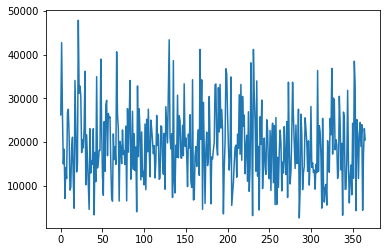

In [7]:
data["y"][data["id"] == 0].plot()
plt.show()

## Train Test Split 

In [8]:
from fklearn.preprocessing.splitting import space_time_split_dataset
train_start = "2016-01-01"
train_end = "2016-06-30"
holdout_end = "2016-12-31"

split_fn = space_time_split_dataset(train_start_date=train_start,
                                     train_end_date=train_end,
                                     holdout_end_date=holdout_end,
                                     split_seed=42, space_holdout_percentage=.05,
                                     space_column="id", time_column="score_date")

In [9]:
train_set, intime_outspace_hdout, outime_inspace_hdout, outime_outspace_hdout = split_fn(data)

train_set.shape, intime_outspace_hdout.shape, outime_inspace_hdout.shape, outime_outspace_hdout.shape

((17195, 6), (905, 6), (18400, 6), (920, 6))

## Define learner function

In [10]:
FEATURES = ["x1", "x2", "x3"]
TARGET = ["y"]

In [11]:
from fklearn.training.imputation import imputer
my_imputer = imputer(columns_to_impute=FEATURES, impute_strategy="median")

In [12]:
from fklearn.training.transformation import standard_scaler
my_scaler = standard_scaler(columns_to_scale=FEATURES)

In [13]:
from fklearn.training.regression import xgb_regression_learner
my_model = xgb_regression_learner(features=['x1', 'x2', 'x3'], target='y', prediction_column='prediction', extra_params={'seed': 139, 'nthread': 8})

In [14]:
from fklearn.training.transformation import ecdfer
my_ecdefer = ecdfer(prediction_column="prediction", ecdf_column="prediction_ecdf")

In [15]:
my_learner = build_pipeline(my_imputer, my_scaler, my_model, my_ecdefer)

## Train

In [16]:
(prediction_function, _, logs) = my_learner(train_set)

In [17]:
logs

{'imputer': {'impute_strategy': 'median',
  'columns_to_impute': ['x1', 'x2', 'x3'],
  'training_proportion_of_nulls': {'x1': 0.0033149171270718232,
   'x2': 0.0024425705146845014,
   'x3': 0.0},
  'statistics': array([ 499.8175411 ,  234.52514314,  793.99846518]),
  'running_time': '0.021 s'},
 'standard_scaler': {'standard_scaler': {'copy': True,
   'with_mean': True,
   'with_std': True},
  'transformed_column': ['x1', 'x2', 'x3'],
  'running_time': '0.007 s'},
 'xgb_regression_learner': {'features': ['x1', 'x2', 'x3'],
  'target': 'y',
  'prediction_column': 'prediction',
  'package': 'xgboost',
  'package_version': '0.72.1',
  'parameters': {'seed': 139,
   'nthread': 8,
   'eta': 0.1,
   'objective': 'reg:linear',
   'num_estimators': 100},
  'feature_importance': {'x2': 2217, 'x3': 418, 'x1': 583},
  'training_samples': 17195,
  'running_time': '1.050 s'},
 'ecdfer': {'nobs': 17195,
  'prediction_column': 'prediction',
  'ascending': True,
  'transformed_column': ['prediction_ec

## Evaluate

In [18]:
my_evaluator = combined_evaluators(evaluators=[
    mean_prediction_evaluator(prediction_column='prediction'),
    r2_evaluator(prediction_column='prediction', target_column='y'),
    mse_evaluator(prediction_column='prediction', target_column='y'),
])

In [19]:
test_predictions = prediction_function(outime_outspace_hdout)

In [20]:
# first argument (training_data) is optional. Only some kinds of evaluators need it. (e.g. learning curve)
# I should probably get rid of it and come up with a better way to pass training information for evaluation
my_evaluator(test_predictions)

{'mean_evaluator__prediction': 19537.5390625,
 'r2_evaluator__y': 0.99867197792173812,
 'mse_evaluator__y': 102416.33603529738}

## Run K-Fold Cross Validation

In [21]:
my_split_fn = k_fold_splitter(n_splits=2, random_state=42)

In [22]:
cv_results = validator(train_set, split_fn=my_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [23]:
base_extractor = evaluator_extractor(evaluator_name='r2_evaluator__y')

In [24]:
extract(cv_results["validator_log"], base_extractor)

[0.99725435276401497, 0.9979054614673678]

## Run Inverse Learning Curve Validation

In [25]:
from fklearn.validation.splitters import reverse_time_learning_curve_splitter

sc_split_fn = reverse_time_learning_curve_splitter(training_time_limit=train_end,
                                                   time_column="score_date", freq="W", min_samples=500)

lc_results = validator(train_set, split_fn=sc_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [26]:
pd_extract(lc_results["validator_log"], pd_evaluator_extractor(evaluator_name='r2_evaluator__y'))

,r2_evaluator__y,fold_num,train_start,train_end,train_size,test_start,test_end,test_size
0,0.995878,0,2016-06-19,2016-06-26,760,2016-06-27,2016-06-29,285
0,0.998479,1,2016-06-12,2016-06-26,1425,2016-06-27,2016-06-29,285
0,0.997979,2,2016-06-05,2016-06-26,2090,2016-06-27,2016-06-29,285
0,0.997849,3,2016-05-29,2016-06-26,2755,2016-06-27,2016-06-29,285
0,0.998497,4,2016-05-22,2016-06-26,3420,2016-06-27,2016-06-29,285
0,0.998297,5,2016-05-15,2016-06-26,4085,2016-06-27,2016-06-29,285
0,0.997534,6,2016-05-08,2016-06-26,4750,2016-06-27,2016-06-29,285
0,0.997528,7,2016-05-01,2016-06-26,5415,2016-06-27,2016-06-29,285
0,0.996994,8,2016-04-24,2016-06-26,6080,2016-06-27,2016-06-29,285
0,0.996445,9,2016-04-17,2016-06-26,6745,2016-06-27,2016-06-29,285


## Run Stability Curve

In [27]:
from fklearn.validation.splitters import stability_curve_time_splitter

sc_split_fn = stability_curve_time_splitter(
    training_time_limit="2016-06-01",
    time_column="score_date",
    freq="M",
    min_samples=1000
)

sc_results = validator(data, split_fn=sc_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [28]:
pd_extract(sc_results["validator_log"], pd_evaluator_extractor(evaluator_name='r2_evaluator__y'))

,r2_evaluator__y,fold_num,train_start,train_end,train_size,test_start,test_end,test_size
0,0.997892,0,2016-01-01,2016-06-01,15300,2016-06-02,2016-06-30,2900
0,0.997554,0,2016-01-01,2016-06-01,15300,2016-07-01,2016-07-31,3100
0,0.998445,0,2016-01-01,2016-06-01,15300,2016-08-01,2016-08-31,3100
0,0.996507,0,2016-01-01,2016-06-01,15300,2016-09-01,2016-09-30,3000
0,0.997117,0,2016-01-01,2016-06-01,15300,2016-10-01,2016-10-31,3100
0,0.996108,0,2016-01-01,2016-06-01,15300,2016-11-01,2016-11-30,3000
0,0.998097,0,2016-01-01,2016-06-01,15300,2016-12-01,2016-12-31,3100


## Run Forward Stability Curve

In [29]:
from fklearn.validation.splitters import forward_stability_curve_time_splitter
from datetime import timedelta

fw_split_fn = forward_stability_curve_time_splitter(
    training_time_start="2016-01-01",
    training_time_end="2016-03-01", 
    holdout_gap=timedelta(days=30),
    holdout_size=timedelta(days=30),
    step=timedelta(days=30),
    time_column="score_date"
)

fw_sc_results = validator(data, split_fn=fw_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [30]:
pd_extract(fw_sc_results["validator_log"], pd_evaluator_extractor(evaluator_name='r2_evaluator__y'))

,r2_evaluator__y,fold_num,train_start,train_end,train_size,test_start,test_end,test_size
0,0.996924,0,2016-01-01,2016-02-29,6000,2016-03-31,2016-04-29,3000
0,0.996263,1,2016-01-31,2016-03-30,6000,2016-04-30,2016-05-29,3000
0,0.996986,2,2016-03-01,2016-04-29,6000,2016-05-30,2016-06-28,3000
0,0.996698,3,2016-03-31,2016-05-29,6000,2016-06-29,2016-07-28,3000
0,0.999124,4,2016-04-30,2016-06-28,6000,2016-07-29,2016-08-27,3000
0,0.997314,5,2016-05-30,2016-07-28,6000,2016-08-28,2016-09-26,3000
0,0.998264,6,2016-06-29,2016-08-27,6000,2016-09-27,2016-10-26,3000
0,0.996098,7,2016-07-29,2016-09-26,6000,2016-10-27,2016-11-25,3000
0,0.997230,8,2016-08-28,2016-10-26,6000,2016-11-26,2016-12-25,3000


## Run Spatial Learning Curve

In [31]:
from fklearn.validation.splitters import spatial_learning_curve_splitter

spatial_split_fn = spatial_learning_curve_splitter(
    space_column="id",
    random_state=0,
    train_percentages=np.linspace(0.1, 1, 10)
)

spatial_lc_results = validator(data, split_fn=spatial_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [32]:
pd_extract(spatial_lc_results["validator_log"], pd_evaluator_extractor(evaluator_name='r2_evaluator__y'))

,r2_evaluator__y,fold_num,train_start,train_end,train_size,test_start,test_end,test_size,percentage
0,0.998462,0,2016-01-01,2016-12-31,2928,2016-01-01,2016-12-31,7320,0.1
0,0.998811,1,2016-01-01,2016-12-31,5856,2016-01-01,2016-12-31,7320,0.2
0,0.998926,2,2016-01-01,2016-12-31,8784,2016-01-01,2016-12-31,7320,0.3
0,0.999139,3,2016-01-01,2016-12-31,11712,2016-01-01,2016-12-31,7320,0.4
0,0.999053,4,2016-01-01,2016-12-31,14640,2016-01-01,2016-12-31,7320,0.5
0,0.999065,5,2016-01-01,2016-12-31,17568,2016-01-01,2016-12-31,7320,0.6
0,0.999316,6,2016-01-01,2016-12-31,20496,2016-01-01,2016-12-31,7320,0.7
0,0.999290,7,2016-01-01,2016-12-31,23424,2016-01-01,2016-12-31,7320,0.8
0,0.999212,8,2016-01-01,2016-12-31,26352,2016-01-01,2016-12-31,7320,0.9
0,0.999339,9,2016-01-01,2016-12-31,29280,2016-01-01,2016-12-31,7320,1.0


## Feature Selection

In [33]:
from fklearn.tuning.selectors import feature_importance_backward_selection

In [34]:
## There might be columns that are features but are also auxiliary for evaluation, add them on the auxiliary list
AUXILIARY_COLUMNS = list(set(train_set.columns) - set(FEATURES))

In [35]:
## Base evaluator is from extractor not pd_extractor!!
base_common_extractor = evaluator_extractor(evaluator_name='r2_evaluator__y')

In [36]:
@fp.curry
def selector_pipeline(features):
    return build_pipeline(imputer(columns_to_impute=features, impute_strategy="median"),
                         standard_scaler(columns_to_scale=features),
                        xgb_regression_learner(features=features, target='y', 
                                               prediction_column='prediction', extra_params={'seed': 139, 'nthread': 8}),
                         ecdfer(prediction_column="prediction", ecdf_column="prediction_ecdf"))

## This training fn is different from standard, still needs to be passed feature argument to become the train_fn!
partial_train_fn = selector_pipeline

In [37]:
logs_fibs = feature_importance_backward_selection(train_set, partial_train_fn, FEATURES, my_split_fn, my_evaluator, 
                                                  base_common_extractor, num_removed_by_step=1,threshold=0.0001,
                                                  early_stop=100, iter_limit=3, min_remaining_features=1)

In [38]:
logs_fibs

[{'train_log': {'imputer': {'impute_strategy': 'median',
    'columns_to_impute': ['x2'],
    'training_proportion_of_nulls': {'x2': 0.0018611143422123998},
    'statistics': array([ 235.02372917]),
    'running_time': '0.004 s'},
   'standard_scaler': {'standard_scaler': {'copy': True,
     'with_mean': True,
     'with_std': True},
    'transformed_column': ['x2'],
    'running_time': '0.002 s'},
   'xgb_regression_learner': {'features': ['x2'],
    'target': 'y',
    'prediction_column': 'prediction',
    'package': 'xgboost',
    'package_version': '0.72.1',
    'parameters': {'seed': 139,
     'nthread': 8,
     'eta': 0.1,
     'objective': 'reg:linear',
     'num_estimators': 100},
    'feature_importance': {'x2': 2612},
    'training_samples': 8597,
    'running_time': '0.261 s'},
   'ecdfer': {'nobs': 8597,
    'prediction_column': 'prediction',
    'ascending': True,
    'transformed_column': ['prediction_ecdf'],
    'running_time': '0.003 s'}},
  'validator_log': [{'fold_num': 0,
    'eval_results': [{'mean_evaluator__prediction': 18924.45703125,
      'r2_evaluator__y': 0.99794022990501507,
      'mse_evaluator__y': 165673.55083138274}],
    'split_log': {'train_size': 8597, 'test_size': 8598}},
   {'fold_num': 1,
    'eval_results': [{'mean_evaluator__prediction': 19128.98828125,
      'r2_evaluator__y': 0.99851282798352947,
      'mse_evaluator__y': 122558.52442595019}],
    'split_log': {'train_size': 8598, 'test_size': 8597}}]},
 {'train_log': {'imputer': {'impute_strategy': 'median',
    'columns_to_impute': ['x2', 'x1'],
    'training_proportion_of_nulls': {'x2': 0.0018611143422123998,
     'x1': 0.0027916715133185993},
    'statistics': array([ 235.02372917,  499.47848215]),
    'running_time': '0.008 s'},
   'standard_scaler': {'standard_scaler': {'copy': True,
     'with_mean': True,
     'with_std': True},
    'transformed_column': ['x2', 'x1'],
    'running_time': '0.004 s'},
   'xgb_regression_learner': {'features': ['x2', 'x1'],
    'target': 'y',
    'prediction_column': 'prediction',
    'package': 'xgboost',
    'package_version': '0.72.1',
    'parameters': {'seed': 139,
     'nthread': 8,
     'eta': 0.1,
     'objective': 'reg:linear',
     'num_estimators': 100},
    'feature_importance': {'x2': 2081, 'x1': 724},
    'training_samples': 8597,
    'running_time': '0.393 s'},
   'ecdfer': {'nobs': 8597,
    'prediction_column': 'prediction',
    'ascending': True,
    'transformed_column': ['prediction_ecdf'],
    'running_time': '0.002 s'}},
  'validator_log': [{'fold_num': 0,
    'eval_results': [{'mean_evaluator__prediction': 18925.61328125,
      'r2_evaluator__y': 0.99705257175995421,
      'mse_evaluator__y': 237070.58546874}],
    'split_log': {'train_size': 8597, 'test_size': 8598}},
   {'fold_num': 1,
    'eval_results': [{'mean_evaluator__prediction': 19129.373046875,
      'r2_evaluator__y': 0.99842329580571765,
      'mse_evaluator__y': 129936.91205005875}],
    'split_log': {'train_size': 8598, 'test_size': 8597}}]},
 {'train_log': {'imputer': {'impute_strategy': 'median',
    'columns_to_impute': ['x1', 'x2', 'x3'],
    'training_proportion_of_nulls': {'x1': 0.0027916715133185993,
     'x2': 0.0018611143422123998,
     'x3': 0.0},
    'statistics': array([ 499.47848215,  235.02372917,  793.18318331]),
    'running_time': '0.010 s'},
   'standard_scaler': {'standard_scaler': {'copy': True,
     'with_mean': True,
     'with_std': True},
    'transformed_column': ['x1', 'x2', 'x3'],
    'running_time': '0.006 s'},
   'xgb_regression_learner': {'features': ['x1', 'x2', 'x3'],
    'target': 'y',
    'prediction_column': 'prediction',
    'package': 'xgboost',
    'package_version': '0.72.1',
    'parameters': {'seed': 139,
     'nthread': 8,
     'eta': 0.1,
     'objective': 'reg:linear',
     'num_estimators': 100},
    'feature_importance': {'x2': 1904, 'x1': 603, 'x3': 402},
    'training_samples': 8597,
    'running_time': '0.513 s'},
   'ecdfer': {'nobs': 8597,
    'prediction_colu

### Quick showing on how to get best features from selection logs

In [39]:
from fklearn.tuning.samplers import get_used_features, _get_avg_metric_from_extractor

In [40]:
used_features = list(fp.map(lambda x: get_used_features(x), logs_fibs))
auc_list = list(fp.map(lambda x: _get_avg_metric_from_extractor(x, base_common_extractor), logs_fibs))
sorted(zip(used_features, auc_list), reverse=True, key=lambda x: x[1])[0]

(['x2'], 0.99822652894427222)

## Interpretability: SHAP

In [41]:
shap.initjs()

In [42]:
holdout = pd.concat((intime_outspace_hdout, outime_inspace_hdout, outime_outspace_hdout))

In [43]:
preds = prediction_function(holdout, apply_shap=True)

In [44]:
shap_values = np.vstack(preds["shap_values"])
shap_expected_value = preds.shap_expected_value.iloc[0]

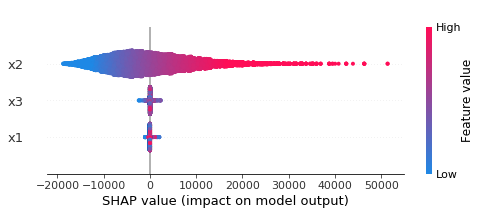

In [45]:
shap.summary_plot(shap_values, preds[FEATURES])

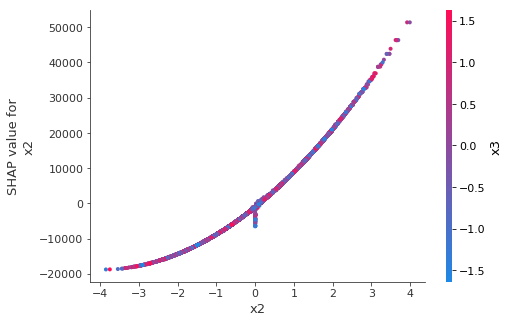

In [46]:
shap.dependence_plot("x2", shap_values, preds[FEATURES])

In [47]:
shap.force_plot(shap_expected_value, shap_values[0, :], preds[FEATURES].iloc[0, :])